### Project 1: Data Exploration, Visualization and Dimensionality Reduction
## Animal Shelter Outcomes: A Classification Problem
#### Alex Matsunami, RJ Smith, Cory Nichols

## Business Understanding


Millions of animal companions end up in shelters each year in the United States. These animals may be stray, rescued from a difficult situation or given up by their previous families. Each year, roughly 40 percent of all dogs and cats in shelters are euthanized. 

Our dataset comes from the Austin Animal Center in Austin, Texas and is part of a Kaggle competition. Using this data, we hope to find trends or rule sets identifying the outcomes of animals in shelters. The findings would subsequently drive shelter practices, hopefully for more social good than business good. For instance, if spaying or neutering a dog or cat is highly suggestive of a favorable outcome for an animal, shelters should implement policies ensuring all animals are fixed prior to adoption. This practice may cost the shelter more money, but would improve the welfare of the animal population. Further, could something as simple as giving each an animal a name drive a more favorable outcome? This particular practice would cost nothing but time and in turn improve the welfare of the animal population in cities. Cost savings, however, could be gained from our analysis. For instance, it may be easy enough to automate intake and processes for certain breeds or genders of animals while focusing attention on breeds or genders of animals that the data indicate "need more help."

We intend to use the 27 thousand records in the training set as a reference for other major cities in the United States, where most animal shelter practices are similar from an intake and outcome perspective. Our dataset includes statistics on breed, color, sex, and age from the Austin Animal Center.

Success should be categorized into analytical and business goals. Analytical goals would be based on classification accuracy on a sizeable test data set given by a confusin matrix where overall classification accuracy is greater than 85% at minimum with at least 85% precision. Further, and possibly more importantly, we hope our analysis drives at least a 20% decrease in animal euthanizations and transfers combined over a two calendar year period.  


## Data Meaning and Data Types

#### Overview

The original shelter outcomes dataset obtained from Kaggle.com contained the following ten attributes: Animal ID, Name, DateTime, OutcomeType, OutcomeSubtype, AnimalType, SexuponOutcome, AgeuponOutcome, Breed, and Color. The training dataset in use is 26,729 records while the test dataset contains roughly 12,000 records. We will be utilizing the training dataset. Each attribute in the training dataset is categorical, with AgeuponOutcome to be converted to continuous. 

#### The Target Feature

OutcomeType is a nominal attribute and our target variable / feature with five levels: Return_to_owner, Euthanasia, Adoption, Transfer, and Died. Adoption is the level of OutcomeType our business clients are particularly interested in increasing, while euthanizations, return_to_owner and transfers are levels of the target feature we are looking to help decrease via data analysis.

OutcomeSubtype is a nominal attribute with 16 categories which represent subcategories of our target variable: OutcomeType. Data is missing for roughly half of the dataset for this feature. OutcomeSubtype is not a critical feature, contains too much missing data and too many levels to efficiently classify, therefore it will likely be dropped. 

#### Explanatory Features

The explanatory features in our dataset are made up of AnimalID, Name, DateTime, AnimalType, SexuponOutcome, AgeuponOutcome, Breed and Color. Perusing the data at a high level, we can easily see that there are many opportunities to split the data into valuable, new features which will help train our classification algorithm more effectively.

AnimalID is a unique identifier given to every animal that enters a shelter. For the purpose of statistical analysis, the Animal ID's or substring of the animal ID does not provide valuable information and will be removed from the dataset. 

Name is a nominal feature with 6374 different names represented in the dataset. This feature may be valuable from a classification standpoint: does a pet being named increase the chances of adoption? The most frequent animal name in our dataset is 'Max.'

DateTime is a temporal feature which denotes the time at which an outcome occurred. In particular, this attribute is useful from a data analysis standpoint only. For instance, do euthanizations occur at a particular point during the day? However, from a classification standpoint, we do not expect this feature to be valuable.

AnimalType is a nominal feature with two levels: Cat and Dog. This feature will likely be a critical feature for classification and data analysis.

SexuponOutcome is a nominal categorical feature with five levels: Neutered Male, Intact Male, Spayed Female, Intact Female, and Unknown. This attribute can easily be split into separate nominal features indcating if an animal is fixed and the gender of the animal. 

AgeuponOutcome is an ordinal feature with 44 levels, or different ages that were reported for animals upon outcome. In order to normalize this feature, we will attempt to convert AgeuponOutcome into days. Examples of levels in this feature include: 1 year, 15 days, 7 months. Each level begins with an integer in every case. The most frequent level is '1 year.'

Breed is a nominal categorical feature with 1380 levels that represent different breeds for both dogs and cats. Breed holds generic levels such as "domestic shorthair" for dogs, which may indicate an inability to truly determine the breed type. We will need to be cognizant of this fact when training our classification model. This feature holds many opportunities for simplification and feature creation and transformation. For instance, we can identify breeds with a 'reputation', size of the animal and popular breeds.

Finally, color is another nominal categorical feature with 366 level that represent the different combination colors of the animals entering the shelter. An example of a level of Color is "Brown/White," with the first color representing the primary color of the animal. Due to the number of levels in the Color feature, aggregation of the levels of color will be needed to effectively train our classification algorithm and derive business impact. 

## Data Preprocessing: Transformation and Statistics 

In [85]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler,Imputer
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [86]:
df = pd.read_csv('~/desktop/train.csv')
breedMap = pd.read_csv('~/desktop/breed_size.csv')
breedMap['Size'] = breedMap.Size.apply(lambda x: x.strip())


Our dataset is made up of 10 variables, many of which can be split or transformed into additional variables. Further, the majority of the variables are categorical: mostly nominal variables except for ordinal variables like Age and temporal variables like DateTime. Some variables, such as AnimalID, will provide no value in our analysis.

Our class feature or target feature is OutcomeType. We are interested in classifying animal outcome types given the other explanatory variables, which we will elaborate upon further. Let's take a look at a few objects to get our feet wet.


### Data Quality and Cleanup

Before we embark on exploratory data analysis and visualization, it's critical our data is clean. This means imputation or dropping missing values and objects if necessary. Below, we will investigate missing values and handle any exceptions in our dataset.

In [87]:
print 'Data types and counts:\n\n', df.info(), '\n\n'
print 'Number of nulls in the data set: \n', df.isnull().sum(),'\n\n'
print '\Data Descriptions: Counts, Frequency'

df.describe()

Data types and counts:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.2+ MB
None 


Number of nulls in the data set: 
AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64 


\Data Descriptions: Counts, Frequency


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824



Based upon the information retrieved from the DataFrame, we are dealing with roughly 27 thousand records in the training set. We are only interested in the "OutcomeType" as our y (classifier) data. Outcome subtype is a sparse drill down on the Outcome type with sub-codes which are not explained thoroughly. Therefore, we recommend dropping this value as it is aub-variable of the outcome variable we are interested with roughly 50% valid values.

The good news is: 40% of animals are being adopted, most of which are neutered male dogs about a year old. 

In regard to new feature creation, we observe multiple opportunities. For instance, it will be interesting to see if having a name affects outcome and if the type of breed is aggressive (has a "reputation"). We can also see converting the AgeuponOutcome being valuable. 

However, before we create or transform features, let's clean up the data a bit more. There are a few nulls in our dataset. Of concern are the nulls in AgeuponOutcome and SexuponOutcome, in which there are 18 and 1 null values, respectively. This is not a large concern given the size of our dataset and what looks to be good quality data overall. However, we will attempt to keep the age nulls in the dataset. Losing one object in the dataset due a null in SexuponOutcome is not a concern. Because we care about whether or not a pet is named, the nulls in Name are not a concern. Further, OutcomeSubtype is simply a click down of OutcomeType, which is our classifier, and is quite sparse. We are dropping OutcomeSubtype, we are not concerned with the nulls.


In [88]:
del df['OutcomeSubtype'], df['AnimalID'] # drop extraneous data  columns
df = df.dropna(subset=['SexuponOutcome']) # drop the one nan row in the sex column. Not a large impact to analysis.
df = df.reset_index() # reset index to ensure further operations are executed correctly

Categorical Filling Strategy:
Fill the nulls with top 3 categories in a column vector randomly for age and sex.
Outside of the nulls, there is a string for age: "0 years" with 22 instances. This provides about "0" value. We will also fill the single "unknown" in the sex column vector with the same logic. 

We will fill these columns by iterating over and randomly choosing one value of the top 3 values instead of assigning an arbitrary value. We believe this is relevant because the top 3 categories are spread relatively similarly, with roughly similar percentages of each column vector.

In [89]:
from collections import Counter
from random import randint
# pandas groupby - group dataset by common attributes - what's the mode 
print 'Number of unique, non nan ages:', len(np.unique(df.AgeuponOutcome[~pd.isnull(df['AgeuponOutcome'])])) 

randChooser = []
for i in ['AgeuponOutcome', 'SexuponOutcome']:
    randChooser.append(Counter(df[i].values).most_common(3)) # get the 3 most common categories

# randomly pick one of the three categories and replace null
df['AgeuponOutcome'] = [randChooser[0][randint(0,2)][0] 
                        if pd.isnull(i) or i.lower() == '0 years' else i for i in df['AgeuponOutcome'].values]
 
df['SexuponOutcome'] = [randChooser[1][randint(0,2)][0]\
                        if i.lower() == 'unknown' else i for i in df['SexuponOutcome'].values]

Number of unique, non nan ages: 44


In [90]:
del df['index']
print 'Number of nulls in the data set: \n', df.isnull().sum(),'\n'
df.head()

Number of nulls in the data set: 
Name              7691
DateTime             0
OutcomeType          0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       0
Breed                0
Color                0
dtype: int64 



,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Data Creation and Transformation


All columns outside of the name column have been dropped or imputed and are now non-null.

Let's create some useful variables in our data set. It would be interesting to investigate whether or not a potential adoptee having a name has an effect on their outcome.

The gender and what we will call "is_intact" (whether an animal is intact (not fixed)) are also interesting variables to investigate.

Further, it would be better to represent age as a continuous ratio variable. We will transform age into day and check it's distribution for normality.


In [91]:
print 'There are %d unique names in the data set' % len(np.unique(df['Name'].values))

# 6375 unique names. That is quite a few names. Let's generalize into a binary feature called has_name instead:
# per Eric's feedback, use pandas functionality instead and do this more efficiently vs pure python list comps:

df['has_name'] = df['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Further, let's split out the intactness of an animal: whether or not the animal has been spayed or neutered
# as well as the gender:

intactness = lambda x: 'Fixed' if x.split()[0] in ['Spayed','Neutered'] else 'Intact'
df['is_fixed'] = df['SexuponOutcome'].apply(intactness)

df['gender'] = df['SexuponOutcome'].apply(lambda x: x.split()[1])

# we will also convert ageuponoutcome into days:
df['AgeValue'] = df['AgeuponOutcome'].apply(lambda x: x.rstrip('s').split())
            
ageMap = {'year': 365, 
          'week': 7, 
          'month': 30,
          'day': 1} 

df['AgeValue'] = df['AgeValue'].apply(lambda x: ageMap.get(x[1])*int(x[0]))

There are 6375 unique names in the data set



Let us also identify potentially 'aggressive' breeds using a bit of regex and top 10 aggressive breeds list: 
http://www.therichest.com/rich-list/the-biggest/the-worlds-10-most-dangerous-dog-breeds/?view=all

We will create a binary feature 'is_aggressive.' If the dog's breed is contained in the aggressive breed list, is_aggressive will be 1, else it will be 0.  


In [92]:
import re

agg_breeds = ['Bull','Doberman','Rottweiler','Husky','German','Boxer','Malamute','Dane']

df['is_aggressive'] = [re.split('\W+',i) for i in df['Breed']]

for idx, i in enumerate(df['is_aggressive'].values):
    if len(agg_breeds) != len(set(agg_breeds).difference(i)):
        df.set_value(idx, 'is_aggressive', 1)
    else:
        df.set_value(idx, 'is_aggressive', 0)      


Let's also grab the primary color using same regex approach and reduce the number of categories in color. We will map the primary color (the first color listed) to a colorMap dictionary.


In [93]:
colorMap = {'exotic':['Agouti','Calico','Lynx','Tricolor','Tortie','Flame','Torbie'], # these are some odd colors...
            'dark':['Black','Chocolate','Liver','Sable','Seal','Red'],
            'neutral':['Gray','Silver','Tan','Buff','Brown','Fawn'],
            'light':['Cream','Blue','Pink','White','Yellow','Lilac','Ruddy','Apricot','Orange','Gold']}

# use pandas built ins to munge the data a bit faster - use rename, split_interval to convert age
df['primary_color'] = [re.split('\W+',i)[0] for i in df['Color']]

for idx, color in enumerate(df['primary_color'].values):
    for k,v in colorMap.items():
        if color in v:
            df.set_value(idx,'primary_color', k)

One other critical attribute we are missing is animal size. We assume the size of an animal is extremely important, especially when it comes to adopting dogs. Therefore, we have retrieved the American Kennel Club's (http://www.akc.org/dog-breeds/) listing of breeds and associated sizes. Because there are so few toy breeds listed, we combined toy and small into "small." For breeds that were not represented in AKC's list (there were about 20), each  was mapped to size buckets based on the following logic: Small (avg weight <= 20 lbs ), Medium (<= 65 lbs), Large (<= 100 lbs), Giant (> 100 lbs). All cats were mapped to "small." We expect the size feature to be more relevant for dogs, and we expect it to be significant. We've also added in an indicator for the top 10 most popular dogs.

In [94]:
# set primary breed as the lookup
df['BreedLU'] = [i.rstrip('Mix').split('/')[0].strip() for i in df['Breed']] 

# zip up breed and size into a dict
sizeMapper = dict(zip(breedMap['Breed'], breedMap['Size'])) 

# map it, I love Pandas
df['size'] = df['BreedLU'].map(sizeMapper) 
df['size'] = np.where(df['AnimalType'].values == 'Cat', 'Small', df['size']) # set cats to small (unless Garfield)
del df['BreedLU'] # drop the lookup vector

In [95]:
# Source: http://www.petinsurance.com/healthzone/pet-articles/pet-breeds/Top-10-Dog-Breeds.aspx
topBreeds = ['Boxer', 'Rottweiler', 'Poodle', 'Yorkshire Terrier',
                'French Bulldog', 'Beagle', 'Bulldog',
                'Golden Retriever', 'German Shepherd', 'Labrador Retriever']

topBreedList = []
for i in df['Breed']:
    matched = False
    for topBreed in topBreeds:
        if topBreed in i:
            topBreedList.append(1)
            matched = True
            break
    if not matched:
        topBreedList.append(0)       

df['is_popular'] = topBreedList

In [96]:
from datetime import datetime
# let's also account for the time of day these actions happen as well as the day of the week
df['DateTime'] = df['DateTime'].astype(np.datetime64)

df['is_Weekday'] = df['DateTime'].apply(lambda x: 1 if datetime.weekday(x) < 5 else 0)

df['time_of_day'] = pd.cut(df.DateTime.dt.hour,[-1,11,17,1e6], 4, labels = [0,1,2])
df['time_of_day'] = df.time_of_day.astype(np.int64)
df['hour'] = df.DateTime.dt.hour
# morning, afternoon, evening

## Variable Investigation And Single Variable Data Visualization

First, let's convert categorical features to objects and make column names a little easier to follow:

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26728 entries, 0 to 26727
Data columns (total 19 columns):
Name              19037 non-null object
DateTime          26728 non-null datetime64[ns]
OutcomeType       26728 non-null object
AnimalType        26728 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26728 non-null object
Breed             26728 non-null object
Color             26728 non-null object
has_name          26728 non-null int64
is_fixed          26728 non-null object
gender            26728 non-null object
AgeValue          26728 non-null int64
is_aggressive     26728 non-null object
primary_color     26728 non-null object
size              26728 non-null object
is_popular        26728 non-null int64
is_Weekday        26728 non-null int64
time_of_day       26728 non-null int64
hour              26728 non-null int64
dtypes: datetime64[ns](1), int64(6), object(12)
memory usage: 4.1+ MB


In [98]:
df.columns = ['Name','DateTime','Outcome','Type','SexuponOutcome','AgeuponOutcome','Breed','Color','Has_Name',
              'Is_Fixed','Gender','Age_Value','Is_Aggressive','Primary_Color','Size', 'Is_Popular','Is_Weekday'
              ,'time_of_day','hour']

categ = ['Type','Breed','Is_Fixed','Gender','Is_Aggressive', 'Primary_Color', 'Size','Has_Name',
       'Outcome','Is_Popular', 'Is_Weekday','time_of_day']

df[categ] = df[categ].astype(np.object)

The data is starting to tell more of a story with our transformed dataset. There are no longer nulls and it looks as if mostly small dogs with names make up a good portion the data set. Nearly 70% of animals in our dataset are fixed. Interestingly, domestic shorthair mixes dominate the data set from a breed perspective, which have 1380 unique values. This may be a "catch all" breed used to identify dogs the shelter had trouble identifying and may be a future issue from a classification standpoint.

We also transformed the age variable into a continuous feature. Let's ensure it has a valid data type and quickly take a look at its distribution and some other key statistics.

In [99]:
df['Age_Value'] = df['Age_Value'].astype(float)
df['logAge'] = np.log(df['Age_Value']).astype(float)
df['sqrtAge'] = np.sqrt(df['Age_Value']).astype(float)
df[['Age_Value','logAge','sqrtAge']].describe()

,Age_Value,logAge,sqrtAge
count,26728.000000,26728.000000,26728.000000
mean,794.157887,5.648803,22.752796
std,1082.343531,1.662430,16.627642
min,1.000000,0.000000,1.000000
25%,60.000000,4.094345,7.745967
50%,365.000000,5.899897,19.104973
75%,1095.000000,6.998510,33.090784
max,7300.000000,8.895630,85.440037


On average, animals are about two years old when adopted. Based simply on the range, age needs to be transformed if we are to use it as a continuous variable. Some animals are one day old upon outcome, while some are as old as 7300 days (20 years!). We will attempt two common methods: the natural log and square root transforms. We will use these transformations for ease of explanation to the business when back transforming and ensuring a more normal distribution for use in classification algorithms. 

Because age was technically a many-leveled categorical variable transformed to a continuous variable, we expect to see a stepped distribution. Because of this we will likely run algorithms with both the continuous and categorical versions of age.

First lets look at the original distribution of age, the log age and sqrt of age in violin plots:

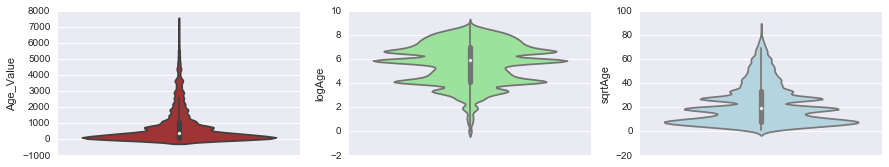

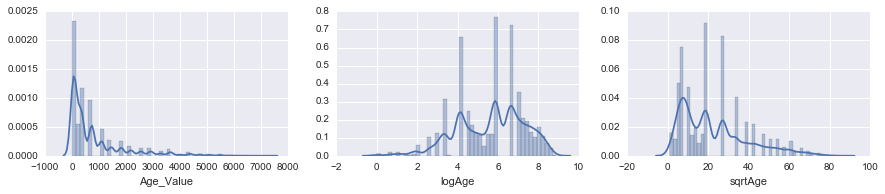

In [100]:
from random import random
c = ['firebrick','lightgreen','lightblue']
atts = ['Age_Value','logAge','sqrtAge']

for i in range(2):
    plt.figure(figsize=(20,15))
    for index, plots in enumerate(atts):
        plt.subplot(5, 4, index + 1) # plot them all on one row
        if i == 0:
            sns.violinplot(y = plots, data= df, color = c[index])
        else: sns.distplot(df[plots])
plt.show()

Violin plots allow us to account for multi-modality while also giving us standard box plot information. These charts plot kernel density estimates on each side of the box plot. As we can see above, our data is very much multi modal.  We also plot histograms and overlayed KDEs and end up with the same outcome. Let's also look at EDFs and normality tests to confirm a lack of age normality:

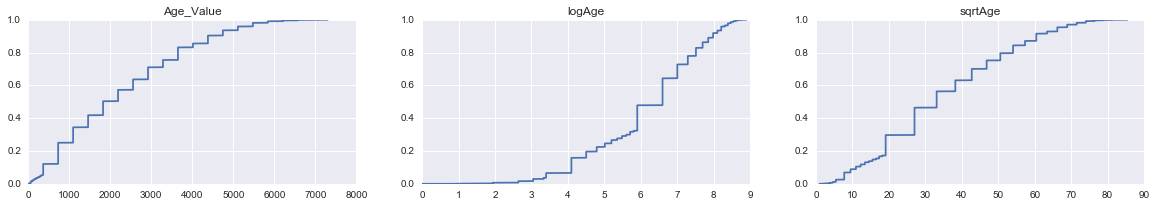

In [101]:
# credit to Eric Larson!
plt.figure(figsize=(20,10))
for index, feature in enumerate(['Age_Value','logAge','sqrtAge']):
    plt.subplot(3, 3 , index + 1)
    x_ax = np.sort(df[feature]) # sort the feature ascending
    y_ax = np.cumsum(x_ax) # take cumulative sum, this creates an array of each observation adding to total sum
    y_ax = y_ax / np.max(y_ax) # get each observation's percentage of total sum of attribute
    plt.plot(x_ax,y_ax) # plot it
    plt.title(feature) # give it a title
    
plt.show()

# It's apparent age is not normally distributed and the transforms dont do much to help us.

In [102]:
from scipy.stats import normaltest
vars = ['Age_Value','logAge','sqrtAge']
for i in vars:
    print i.ljust(10), 'chi-square:', round(normaltest(df[i])[0]), '\tp-value: {:.2f}'.format(normaltest(df[i])[1])

Age_Value  chi-square: 11282.0 	p-value: 0.00
logAge     chi-square: 917.0 	p-value: 0.00
sqrtAge    chi-square: 3269.0 	p-value: 0.00


As shown above, the numerically converted Age is right skewed with a median value of about 365 days. This skewness is attributed to the younger ages of adopted animals. Empirical distribution functions show our data in a more quantitative fashion: showing probabilities of of obtaining values on the y axis and the value range itself on the x-axis. For instance, there is roughly an 85% chance of finding an age less than 4000 days in our dataset. We are looking for a relatively smooth upward curve that is not skewed severely 

Transforming the feature Age into a log representation and sqrt representation doesn't provide gaussian distributions, confirmed by EDF plots and D'Agostino's normal test. Depending on the classification algorithm used, we will likely need to utilize a categorical variable with levels for Age. Let's go ahead and create that feature now.

In [103]:
# let's convert age to an age range, if an animal is a year or less: young, up to 8 years: adult, 8+ years: senior
df['age_range'] = pd.cut(df.Age_Value/365,[0, 1, 8, 1e6],3, labels=['a_young', 'b_adult', 'c_senior'])
del df['logAge']
del df['sqrtAge']

Now that we've thoroughly analyzed and visualized age, we will move on to categorical variables. The rest of our dataset is primarily categorical (both nominal and ordinal variables). Visualizations of counts will be the priority. Of interest in particular are the variables we spent a significant amount of time creating, such as size and aggressive breeds.

To be thorough let's go ahead and plot percentage bars and investigate counts, which is common for individual categorical variables:

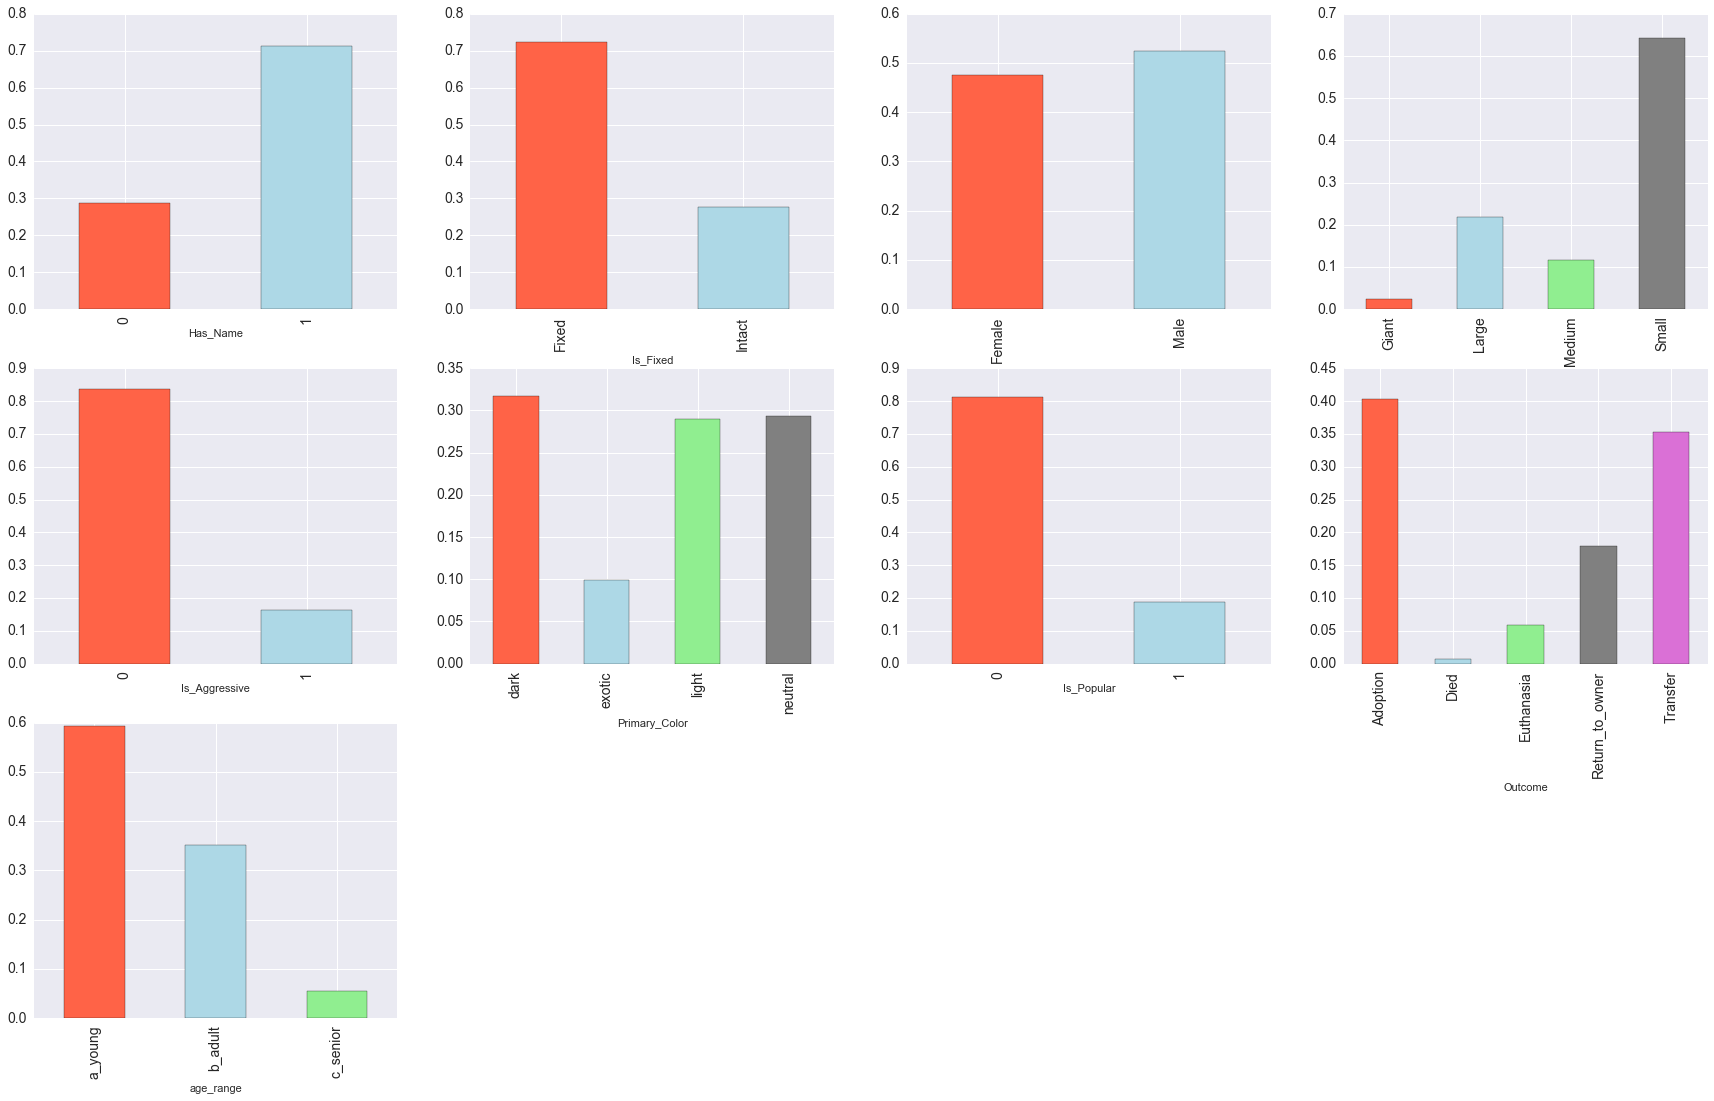

In [104]:
import matplotlib

features = ['Has_Name','Is_Fixed','Gender','Size','Is_Aggressive','Primary_Color', 'Is_Popular','Outcome','age_range']

plt.figure(figsize=(30,18))
for index, feature in enumerate(features):
    plt.subplot(3, 4, index +1)
    groups = df.groupby(feature)['Outcome'].count()/len(df)
    ax = groups.plot(kind = 'bar', color =['tomato','lightblue','lightgreen','gray','orchid'], fontsize=14)

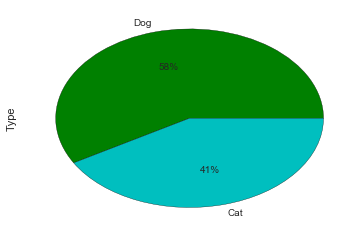

In [105]:
df.Type.value_counts().plot(kind='pie', autopct='%1d%%', colors = ['g', 'c'])

Some interesting discoveries come out of simple percentages: for instance, most animals being adopted are small. This is likely because cats are also categorized into the small category -- we will explore animal type crosstabs more thoroughly. Most critically, adoption rates show promise: 40 percent of all animals are adopted. Our business partners are looking to increase this number. Further, given Austin's policy of no euthanizations unless aggressive or sick, it's easy to see that most animals do indeed survive, however, most are transferred to other shelters. Transfers come with high cost for our business partners. This is likely a metric they'd like to reduce. The more an animal is passed through the system, the larger emotional detriment and the higher cost for the shelters in managing input/output as well as standard medical treatment, room and board and surgical operations. Further, it looks as though the most popular breeds are not present in the sample of shelter animals, which could be a bad sign for future adoptability.

Based on these charts, we also likely can combine size into a three level factor feature by combining giant into large since it is about 2% of the dataset. Further, most animals are dark colored and fixed. Fixed animals make up almost 75% of the dataset while dark colored animals are 40% of the sample size.

Further, there are more dogs than cats in our dataset. This is actually a surprise, given that stray cats are far more frequently encountered than stray dogs. 

## Feature Relationships, Correlative Analysis and Further Visualizations

Visualizing relationships of categorical variables can be difficult. However, we're going to start with a mosaic plot (tree map) to show relative sizes of categorical variables and how they interact with one another. First, we are going to investigate the type of animal, split and sized by Is_Intact and Size

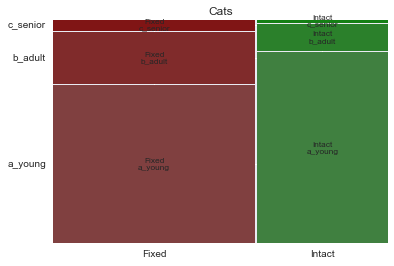

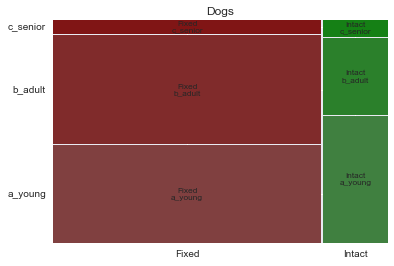

In [106]:
# mosaic plot for dogs on size and color
from statsmodels.graphics.mosaicplot import mosaic
for i in np.unique(df['Type']):
    mosaic(df[df['Type'] == i], ['Is_Fixed','age_range']),
    plt.title(i+'s')
    plt.show()

We immediately see that most animals are fixed, which is something we could tell with univariate analysis. However, for both dogs and cats, we notice that younger animals in general have a higher rate of being intact. This is likely because the animals are newer arrivals, however, our dataset does not contain temporal data in order to determine this effect. 

Is_Aggressive          False      True 
Size   age_range                       
Giant  a_young     71.147541  28.852459
       b_adult     53.535354  46.464646
       c_senior    48.571429  51.428571
Large  a_young     42.121849  57.878151
       b_adult     33.420074  66.579926
       c_senior    49.834983  50.165017
Medium a_young     85.490932  14.509068
       b_adult     83.436533  16.563467
       c_senior    88.205128  11.794872
Small  a_young     98.848750   1.151250
       b_adult     99.392713   0.607287
       c_senior   100.000000   0.000000


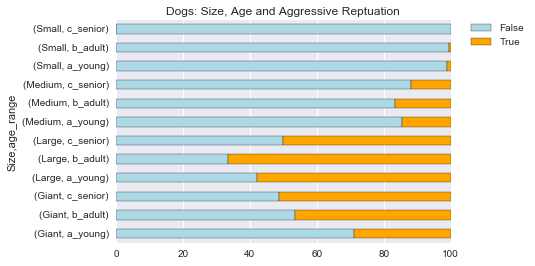

In [107]:
dfdogs = df[df.Type == 'Dog']
dogs = pd.crosstab([dfdogs['Size'], dfdogs['age_range']], dfdogs.Is_Aggressive.astype(bool))
dogs_rate = dogs.div(dogs.sum(1).astype(float), axis=0)*100
print dogs_rate
dogs_rate.plot(kind='barh', stacked=True, color =['lightblue','orange'], legend=False)
plt.title('Dogs: Size, Age and Aggressive Reptuation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Here, we are looking at dog age ranges and aggressiveness. Some interesting trends are readily apparent: large, adult dogs tend to be more 'aggressive' breeds, even moreso than giant dogs. As expected, small dogs don't have much of a reptuation of being 'dangerous' or aggressive. 

### Additional Work: Algorithmic Setup and Numeric Conversions

To make things a bit easier to visualize in seaborn and also set up our data for classification algorithms, let's go ahead and set up dummies and remap some of our categorical variables to integers where appropriate.

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26728 entries, 0 to 26727
Data columns (total 20 columns):
Name              19037 non-null object
DateTime          26728 non-null datetime64[ns]
Outcome           26728 non-null object
Type              26728 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26728 non-null object
Breed             26728 non-null object
Color             26728 non-null object
Has_Name          26728 non-null object
Is_Fixed          26728 non-null object
Gender            26728 non-null object
Age_Value         26728 non-null float64
Is_Aggressive     26728 non-null object
Primary_Color     26728 non-null object
Size              26728 non-null object
Is_Popular        26728 non-null object
Is_Weekday        26728 non-null object
time_of_day       26728 non-null object
hour              26728 non-null int64
age_range         26728 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(16)
memory u

In [109]:
# size is ordinal, lets create a dict and map it
sizeMap = {'Giant':4,'Large':3,'Medium':2,'Small':1}
df['Size'] = df['Size'].map(sizeMap)

# grab dummies for our nominal variables
df = df.join(pd.get_dummies(df['Primary_Color']))

# relabel our outcomes
classLabels = LabelEncoder()
df['Outcome_Label'] = classLabels.fit_transform(df['Outcome']) 
df['Primary_Color_Label'] = classLabels.fit_transform(df['Primary_Color']) 

Now, let's take a look at more relationships between our explanatory features. Specifically the age_value, size and intactness of dogs:

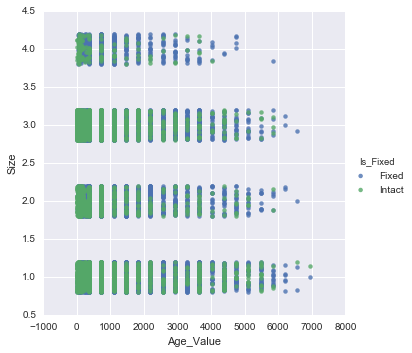

In [110]:
sns.lmplot("Age_Value", "Size", data=df[df.Type=='Dog'], hue = 'Is_Fixed', x_jitter=.2, y_jitter =.2, fit_reg=False)

This interesting scatterplot gives us a number of different pieces of valuable information on the dogs in our dataset. First, smaller dogs are the most frequently occurring of the sizes in our dataset, and also contain the oldest of the dogs. By jittering our data points, it looks as if larger sized dogs are fixed more often than other sizes. We also can easily confirm that younger dogs are intact more often than older dogs.

Lookup:
['dark' 'exotic' 'light' 'neutral']


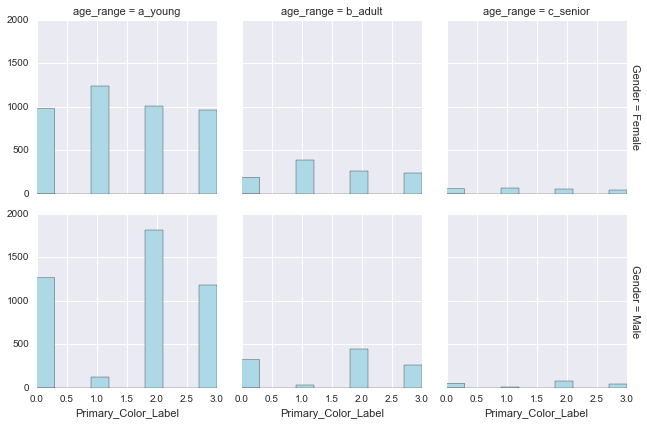

In [111]:
#df[df.Type=='Cat']
print 'Lookup:' 
print np.unique(classLabels.inverse_transform(df['Primary_Color_Label']))
g = sns.FacetGrid(df[df.Type =='Cat'], col = "age_range", row= "Gender", margin_titles=True)
g.map(plt.hist, "Primary_Color_Label" , color= "lightblue")

Looking at the distributions of our categorical variables, age range, gender and color, we can see that light colored, young males make up a large portion of our cats. There are few senior aged cats in our dataset in comparison to young cats. This is likely due to the high birth rates and litter sizes of cats. It is often common to see many kittens and few old cats in animal shelters when adopting. Interestingly, there are also many exotic colored female cats.

## Feature and Target: Visual Relationships and Analysis

Let's take a look at a formal test and visualization to see how our features relate to the outcome label. By using a chi-square test of independence, we will attempt to determine if our features are truly independent (not related) to outcome or if there is a relationship (dependency). Significance thresholds are set at .05.

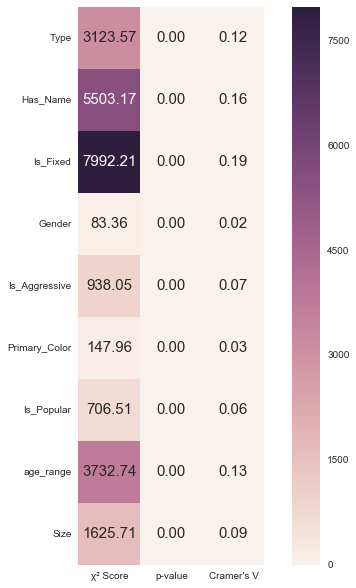

In [112]:
import scipy

cols = ['Type','Has_Name','Is_Fixed','Gender','Is_Aggressive','Primary_Color','Is_Popular','age_range','Size']

def chisqr(df, features):
    vals = []
    for i in features:
        cross = pd.crosstab(df[i], df['Outcome_Label'])
        chisq = scipy.stats.chi2_contingency(cross)
        cramer = np.sqrt((chisq[0]/len(df)) / np.minimum(len(df)-1,len(cols)-1))
        chisq = list(chisq[0:2])
        chisq.append(cramer)
        vals.append(chisq)
    return DataFrame(vals)

chi2 = u'\N{GREEK SMALL LETTER CHI}\N{SUPERSCRIPT TWO}'
plt.figure(figsize=(10,10))
hm = sns.heatmap(chisqr(df,cols),cbar=True,annot=True,square=True, fmt='.2f',annot_kws={'size':15},
                 yticklabels=cols,xticklabels=[chi2 + ' Score','p-value','Cramer\'s V'])
plt.show()

Based on a chi-squared test of independence, we determine that our categorical features are all significantly related to our target variable Outcome. In fact, the most dependent variable is Is_Intact, essentially stating that Outcome is highly dependent upon whether or not an animal is fixed. We also take a look at the effect size to determine the strength of association. As we can see, the strength of association between Is_Intact and Outcome is the highest at .19, which is only moderately associated. Most of the other categorical variables are either weakly or moderately associated with outcome. Of the variables, Is_Intact, age_range, has_name and Type would be our best predictors. Surprisingly, gender's effect size is quite small -- insignificant in fact, as well as the primary color of the animal.

Let's cut our visualizations a couple different ways now, based on these results.

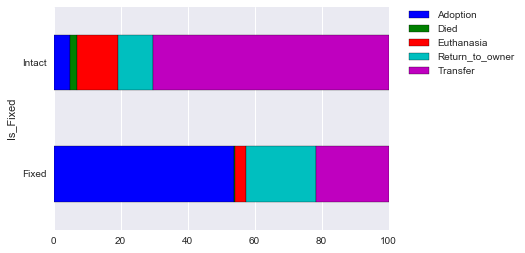

In [113]:
animals = pd.crosstab(df['Is_Fixed'], df['Outcome'])
rate = animals.div(animals.sum(1).astype(float), axis=0)*100
rate.plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

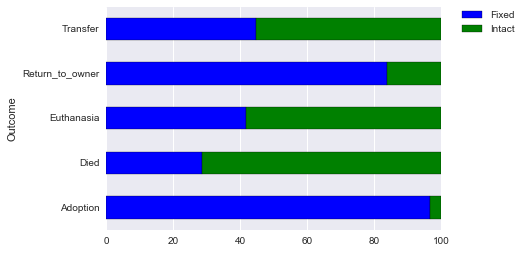

In [114]:
animals = pd.crosstab(df['Outcome'], df['Is_Fixed'])
rate = animals.div(animals.sum(1).astype(float), axis=0)*100
rate.plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Probably the most significant finding thus far: it looks as if over 50 percent of fixed animals are adopted. Specifically, looking at the second chart, over 90 percent of adopted animals are fixed. Given the moderate association found for Is_Intact, this is a critical datapoint discovered for our classification purposes going forward. Further, the majority of animals that perished were intact. This could be due to pre-existing conditions coming into the facility.

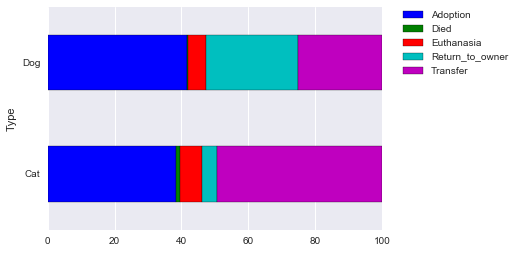

In [115]:
animals = pd.crosstab(df['Type'], df['Outcome'])
rate = animals.div(animals.sum(1).astype(float), axis=0)*100
rate.plot(kind='barh',stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Cats are transferred far more often than dogs, however, both are adopted at similar rate. Dogs are much more likely to be returned to their owners than cats. Of interest is the deaths among cats and dogs: only cats have died in our dataset. Thankfully both cats and dogs do not die or are not euthanized often. 

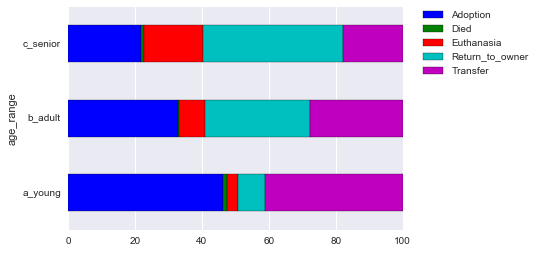

In [116]:
animals = pd.crosstab(df['age_range'], df['Outcome'])
rate = animals.div(animals.sum(1).astype(float), axis=0)*100
rate.plot(kind='barh',stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As one could probably expect, young animals are adopted at higher rates than adult or senior animals. The highest rates of euthanasia occur in senior animals, likely due to failing health. Return to owners are also high in senior animals, most likely due to the inability for more senior animals to be adopted. Because age_range has a slight association with outcome and is one more the more associated features in our dataset, these are valuable findings prior to executing classification procedures.

## Preliminary Conclusion

Based on exploratory data analysis, our next step is to ensure our data is ready for learning a classification algorithm such as a decision tree or logistic regression. We can obviously use the information from the EDA performed to tweak parameters in our model or add weights appropriately, such as adding importance for intactness.

However, based on standard exploratory data analysis, we can provide the business with valuable feedback: fix your animals if you want them to be adopted. Further, popular breed types and size of the animal don't seem to factor heavily into the outcome for the animal.

# Mini-Lab Start : Logistic Regression and Support Vector Machines

Based on exploratory data analysis, some initial conclusions were made: we could easily see that fixing animals has a significant effect on their ability to be adopted, simply by visualizing the data and running basic statistical tests. 

However, we figured we were missing a few variables. In particular, the time of the outcome. Understanding when outcomes happen could be a critical component in understanding what optimal times or days our business partners should stay open or promote adoptive benefits heavily. 

Further, in order to answer the question more succintly, we have reduced our problem to a binary one: adopted or not. Given a binary outcome, there is roughly a 45/55 split on adopted and not adopted outcomes, respectively. 

A binary outcome will help to explain classification models more effectively and answer our business partner's question more directly: what variables are the most important for ADOPTION?


The first thing we need to do is get our data into algorithmic shape. We intend to use two methodologies to build a classification model predicting binary outcomes. These two methodologies are Logistic Regression and Support Vector Machines.

Given the linear separation dependency of Logistic Regression, we find it critical to attempt a non-linear classification algorithm with a Support Vector Machine. We will also fit a linear SVM to the data as well.

This should help us to not only fit a predictive model, but to also create a description for the answer to our the question: "How can we get more animals adopted?"

Let's go ahead and clean our data up. We have quite a few features left over, simply for visualization purposes.

In [117]:
df.head()

,Name,DateTime,Outcome,Type,SexuponOutcome,AgeuponOutcome,Breed,Color,Has_Name,Is_Fixed,...,Is_Weekday,time_of_day,hour,age_range,dark,exotic,light,neutral,Outcome_Label,Primary_Color_Label
0,Hambone,2014-02-13 00:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,Fixed,...,1,0,0,a_young,0,0,0,1,3,3
1,Emily,2013-10-13 17:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,Fixed,...,0,1,17,a_young,0,0,1,0,2,2
2,Pearce,2015-01-31 18:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,Fixed,...,0,2,18,b_adult,0,0,1,0,0,2
3,NaN,2014-07-12 00:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,Intact,...,0,0,0,a_young,0,0,1,0,4,2
4,NaN,2013-11-15 18:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,Fixed,...,1,2,18,b_adult,0,0,0,1,4,3


We'll create a new dataframe called df_alg (for df_algorithm), and discretize our mostly categorical dataset. 

We've also included our new time features for good measure: time_of_day, is_weekday, and hour. These variables are ordinal, binary and continuous in nature, they do not require dummies and the range on hour is 24. 

In [118]:
for c in np.unique(df['Outcome']):
    print c, df.Outcome[df.Outcome == c].count()

# given such a low representation for died and euthanasia, it would be better to make this a binary outcome
# we will group all other values except adoption

# grab a new dataframe
df_alg = df[['Is_Fixed','Has_Name','Type','Is_Aggressive','Size','Is_Popular','age_range',
             'Gender','dark','exotic','light','neutral','Is_Weekday','time_of_day','hour','Outcome_Label']]

df_alg.loc[:,'Outcome_Label'] = df.loc[:,'Outcome'].apply(lambda x: 1 if x == 'Adoption' else 0)
df_alg.loc[:,'Is_Fixed'] = df.loc[:,'Is_Fixed'].apply(lambda x: 1 if x == 'Fixed' else 0)

# now let's line up the rest of our features to get ready for logistic regression and SVM
df_alg.loc[:,'Type'] = df.loc[:,'Type'].apply(lambda x: 1 if x == 'Dog' else 0)
df_alg.loc[:,'Gender'] = df.loc[:,'Gender'].apply(lambda x: 1 if x == 'Male' else 0)

df_alg.loc[:,'age_range'] = classLabels.fit_transform(df.loc[:,'age_range'])
df_alg.loc[:,'Size'] = classLabels.fit_transform(df.loc[:,'Size'])

df_alg = df_alg.astype(np.int64)

Adoption 10769
Died 197
Euthanasia 1555
Return_to_owner 4785
Transfer 9422


## LOGISTIC REGRESSION

Now that we have a binary outcome we're interested in, we'll go ahead and fit a logistic regression model to the full feature set we just created and perform model selection on the data. (this is assuming we don't create a validation set from our training data as we haven't gotten there yet on lesson plan). 

However, in order to test effectively and ensure class balances in each split, we will use StratifiedShuffleSplit from sklearn. 

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

scl = StandardScaler()
lr = LogisticRegression()
X_train = df_alg.values[:, :-1] # features
y_train = df_alg.values[:, -1] # target, binary

cv_object =  StratifiedShuffleSplit(y=y,
                                    n_iter= 5,
                                    test_size  = 0.2)

Since we have included an hour feature, it would be best to scale our data. Hour's range is 24, while the second largest range is 3, for age_range. Thus we will standardize our data appropriately to represent weights correctly and help us choose which variables are the most important in our model. Unfortunately, we cannot reduce dimensionality in this case with standard methods like PCA and LDA because of such a categorical heavy dataset.

Let's take a quick look at our accuracy on 3 shuffles with standardized data using an out of the box logistic regression model:

In [140]:
accuracies = cross_val_score(lr, scl.fit_transform(X), y=y, cv=cv_object, verbose= 0) # this also can help with parallelism
print(accuracies)

[ 0.73550318  0.73138795  0.7328844   0.7345679   0.73101384]


Let's also check out our accuracy across penalty and cost parameters:

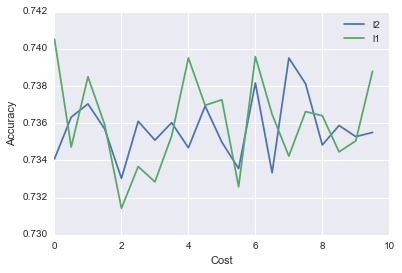

In [143]:
costs = np.arange(0.001,10,0.5)

l2s = []
l1s = []
for i in costs:
    for j in ['l1','l2']:
        lr2 = LogisticRegression(penalty = j,C = i)
        accuracies = np.average(cross_val_score(lr2, scl.fit_transform(X), y=y, cv=cv_object, verbose= 0))
        if j == 'l1':
            l1s.append(accuracies)
        else:
            l2s.append(accuracies)
# best accuracy @ cost of zero (max reg for logit) using l2 regularlization
plt.plot(costs, l2s)
plt.plot(costs, l1s)
plt.legend(['l2','l1'])
plt.ylabel('Accuracy')
plt.xlabel('Cost')
plt.show()

74% on our training set is not great, but it's better than random selection. That being said, we can definitely tune our model to understand how regularlization can help (or hinder) or classification accuracy. It looks as if l1 (LASSO) penalty is our optimal parameter setting for our training set. This will give us sparseness in our parameters, allowing us to simplify our model moreso than l2 (ridge). However, we need to first use our validation set to confirm our findings. 

First, let's take a look at our accuracy rate again, this time using five fold stratified cross validation and the number of observations in our data set. Let's look at our learning curve and the variability associated with our training and validation sets:

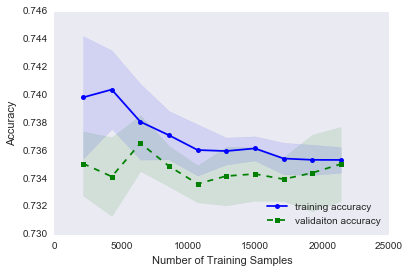

In [145]:
# playing with pipelines, adapted from Rauschka
from sklearn.learning_curve import learning_curve # uses stratified k fold by default

pipe_lr = Pipeline([('scl', StandardScaler()),('clf', LogisticRegression(penalty='l1'))]) # set up pipeline, 
                                                                                        # automatically scale
train_sizes, train_scores, valid_scores = learning_curve(estimator=pipe_lr, 
                                                        X = X_train, 
                                                        y = y_train, 
                                                        train_sizes = np.linspace(0.1, 1.0, 10) ,# spacing of samples, 
                                                        cv = 5, # 5 fold
                                                        n_jobs = -1) # use all processors
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, c='blue', marker='o',  markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, c='green', marker='s', linestyle='--',  markersize=5, label='validaiton accuracy')
plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1, color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

What we can see is that we do not generalize well to our validation set in our training data when the number of samples is low -- we see high variance and overfitting. Validation lags behind training accuracy on average until about 25,000 samples. There is better generalization with a larger number of samples. As expected, the validation result does have a higher variance in this case, but in general, more samples (as expected) benefits the accuracy of our model. 

Let's tune the critical parameters of Logistic Regression: regularlization cost and penalty directly. We'll interactively test the parameters below and visualize optimal cost and penalties for our dataset.

In [146]:
from ipywidgets import widgets as wd
from sklearn.metrics import roc_curve

def lr_explore(cost, penalty):
    lr = LogisticRegression(penalty=penalty, C=cost, class_weight=None) 
    accuracies = cross_val_score(lr, scl.fit_transform(X), y, cv=cv_object) 
    print 'Average Accuracy:', np.average(accuracies)
    
wd.interact(lr_explore, cost=(0.001,10.0,0.05), penalty =['l1','l2'])

Average Accuracy: 0.742386831276


After confirming l1 penalty with a large amount of regularlization is optimal for fitting our model let's take a look directly at a visual of our regularlization parameter C:

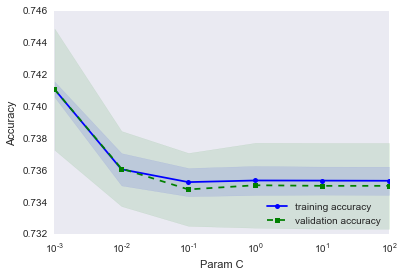

In [148]:
# take a look at C levels and associated accuracy on a stratified 5 fold CV
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, valid_scores = validation_curve(
                                             estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__C',
                                             param_range = param_range,
                                             cv = 5
                                             )
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.1, color='blue')
plt.plot(param_range, valid_mean, color='green', marker='s', linestyle='--', markersize=5,label='validation accuracy')
plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha = 0.1, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Param C')
plt.ylabel('Accuracy')
plt.show()

                                    

With a large amount of regularlization, we can see that our validation and training sets are almost identical. This indicates we are NOT overfitting our model with a large C hyperparameter using LASSO (l1 penalty). Therefore, it's optimal we move forward with l1 and a large C. 

Note: sklearn's C parameter is an INVERSE regularlization parameter for logistic regression, the lower, the more regularlization in the model.

Now, let's repeat our 80/20 split on our entire training set using shuffles to see if we've improved based on our research.

In [165]:
lr_final = LogisticRegression(penalty='l1', C=0.001)
accuracies = cross_val_score(lr_final, scl.fit_transform(X), y, cv=cv_object) 
print np.average(accuracies)

0.742723531612


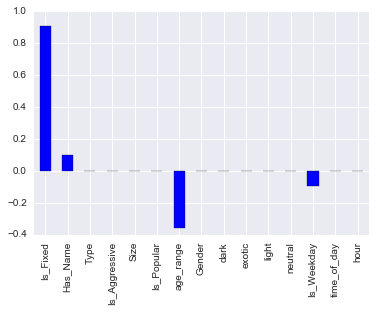

In [166]:
lr_final.fit(scl.fit_transform(X),y)
weights = pd.Series(lr_final.coef_[0], index=df_alg.columns[:-1])
weights.plot(kind='bar')
plt.show()
# LASSO results show we can eliminate pretty much everything outside of is_fixed and age_range (woot)

## Interpreting Logistic Regression Weights

Even though our model is only around 74% accurate on our validation dataset, we have obvious opportunities to simplify. The standardized data has resulted in a sparse coefficient array for our Logistic Regression model. This is one of the main benefits of utilizing a LASSO approach. 

Is_Fixed (0.91) is obviously the most important attribute in determining whether or not an animal is adopted. If an animal is fixed, it's more likely to be adopted. Age (-.36), as well, is quite important. The younger, the more likely to be adopted.

These variables, from experience and domain knowledge, were expected to be highly important. Spaying and neutering is cost prohibitive for some consumers, and the average adoptor is almost always interested in younger animals. Further, most owners do no want animals who are capable of reporoducing. Age is important because of potential health risks and maximum anticipated time with the animal. However, these assumptions are purely anecdotal and would need to be tested themselves. That being said, the ultimate conclusion given the result above is not surprising. 

What is interesting, however, is the lack of importance when it comes to size. This could be a result of the binarization process, in which size categories were created and may need to be revisited. 

The business result confirms our initial suspicions: fix the animals, name them and make them available on the weekend to maximize the chance of adoption. Our business partners cannot do anything about age.

The analytical result allows us to move forward with a two feature model, including age_range and Is_Fixed. 

In [190]:
X_reduced = df_alg[['Is_Fixed','age_range']].values
lr_reduced = LogisticRegression(penalty='l1', C=0.01)
lr_reduced.fit(X_reduced, y)
accuracies = cross_val_score(lr_final, scl.fit_transform(X), y, cv=cv_object)
print(np.average(accuracies))

0.738720538721


In [191]:
from  matplotlib.colors import ListedColormap # credit: Sebastian Rauschka: Python Machine Learning
def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    # set up marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() +1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() +1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
                   alpha=0.8,c=cmap(idx),
                   marker=markers[idx],label=cl)
        
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:,0],X_test[:,1],c='',
                   alpha=1.0,linewidths=1,marker='o',
                   s=55,label='test set')

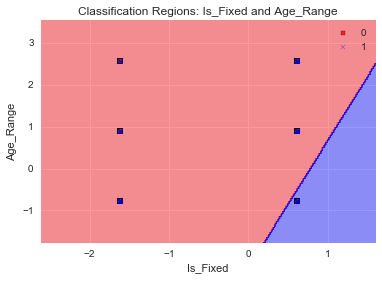

In [192]:
plot_decision_regions(scl.fit_transform(X_reduced), y, lr_reduced)
plt.xlabel('Is_Fixed')
plt.ylabel('Age_Range')
plt.title('Classification Regions: Is_Fixed and Age_Range')
plt.legend(loc='best')
plt.show()

Our decision regions visually show that fixed, young animals are adopted. While older animals have less of a chance to be adopted, even if they are fixed. 

We still maintain 74% accuracy, after reducing the amount of features in our dataset to only two.

## Logistic Regression Conclusion

74% accuracy is better than random chance, however, our classification model can likely be improved by gathering critical features, such as pre-existing medical conditions, if the animal has reproduced before and solidifying whether or not an animal truly is aggressive, instead of using arbitrary lists to identify aggressive breeds. We believe this would push our model accuracy over 80% and provide a more holistic conclusion on what factors drive adoption for our business partners.

In [194]:
# extra, playing with ROC
'''
from sklearn.metrics import roc_curve, auc, accuracy_score # check area under curve score for ROC

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, lr.predict(scl.fit_transform(X)))
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,'b',
label='Area Under Curve = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1]), plt.ylim([-0.1,1.1])
plt.ylabel('TPR'), plt.xlabel('FPR'), plt.title('ROC Curve')
plt.show()
'''

"\nfrom sklearn.metrics import roc_curve, auc, accuracy_score # check area under curve score for ROC\n\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y, lr.predict(scl.fit_transform(X)))\nroc_auc = auc(false_positive_rate, true_positive_rate)\nplt.plot(false_positive_rate, true_positive_rate,'b',\nlabel='Area Under Curve = %0.2f'% roc_auc)\nplt.legend(loc='lower right')\nplt.plot([0,1],[0,1],'r--')\nplt.xlim([-0.1,1.1]), plt.ylim([-0.1,1.1])\nplt.ylabel('TPR'), plt.xlabel('FPR'), plt.title('ROC Curve')\nplt.show()\n"